<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [2]:
from __future__ import print_function
from __future__ import absolute_import

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Interpolation

Interpolation is a fundamental numerical problem that is central to many other numerical algorithms.  Simply put, given a finite number of points where values are known,  find an *interpolant*, a (usually) continuous function that returns values everywhere and is guaranteed to pass through the known data.  

## Objectives: 

* Define an interpolant
* Understand **Polynomial** Interpolation
    * Define the interpolating polynomial $P_N(x)$ that exactly interpolates $N+1$ points
    * Calculation (in the monomial basis)
    * Uniqueness
    * Other bases (Lagrange, Newton?)
    * Error Analysis
    * Chebyshev Polynomials and optimal interpolation
* Understand Other interpolants
    * Piecewise Polynomial interpolation
    * Overlapping Polynomial interpolation
    * Cubic Splines and other smooth interpolants
    * Higher dimensional Interpolation schemes and scipy.interpolate
    

### Interpolation (vs  Fitting)

**Definition:**  Given a discrete set of values $y_i$ at locations $x_i$, an **interpolant** is a (piece-wise) continuous function $f(x)$ that passes exactly through the data (*i.e.* $f(x_i) = y_i$).

A visual example for 3 random points

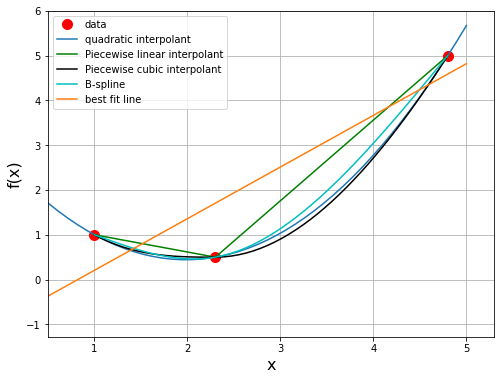

In [8]:
from scipy.interpolate import pchip_interpolate, make_interp_spline

N= 3
x = [ 1, 2.3, 4.8 ]
y = [ 1., 0.5, 5.0]
p2 = numpy.polyfit(x,y,2)
p1 = numpy.polyfit(x,y,1)

b_spline = make_interp_spline(x, y, bc_type="natural") 

xa = numpy.linspace(0.,5)
xs = numpy.linspace(x[0],x[-1])

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(x,y,'ro',markersize=10,label='data')
axes.plot(xa,numpy.polyval(p2, xa), label='quadratic interpolant')
axes.plot(x,y,'g', label='Piecewise linear interpolant')
axes.plot(xs,pchip_interpolate(x,y,xs),'k', label='Piecewise cubic interpolant')
axes.plot(xs,b_spline(xs),'c', label='B-spline')


axes.plot(xa,numpy.polyval(p1, xa), label='best fit line')
axes.legend(loc='best')
axes.set_xlim(min(x) - 0.5,max(x) + 0.5)
axes.set_xlabel('x',fontsize=16)
axes.set_ylabel('f(x)',fontsize=16)

axes.grid()
plt.show()

**Comment**:
In general a polynomial of degree $N$ can be used to interpolate $N+1$ data points. There are many choices of functions to use to interpolate values, but here we focus on polynomials.

## Applications

 - Data filling
 - Function approximation
 - Fundamental component of other algorithms
   - Root finding (secant method)
   - Optimization, minima/maxima (successive parabolic interpolation)
   - Numerical integration and differentiation
   - The Finite Element Method
   

## Polynomial Interpolation

**Theorem:**  There is a *unique* polynomial of degree $N$, $P_N(x)$, that passes exactly through $N + 1$ values $y_0, y_1, \ldots, y_N $ at *distinct* points $x_0, x_1, \ldots, x_N$.

Consequence of the number of unknowns in $P_N(x)$.

#### Example 1: 2 Points

Given two points $(x_0, y_0)$ and $(x_1, y_1)$, There is a unique line 

$$P_1(x) = p_0 + p_1 x$$

that connects them. We simply need to use the data to find $p_0$ and $p_1$:

We first note that we have two equations and two unknowns. The two equations can be found by assuming the function $P_1(x)$ interpolates the two data points

$$
    \begin{matrix}
       P_1(x_0) = & p_0 + p_1 x_0  =& y_0  \\
       P_1(x_1) =& p_0 + p_1 x_1 = &   y_1 \\
    \end{matrix}
$$

We can also (and should) write this problem as a small $2\times2$ linear algebra problem $A\mathbf{x}=\mathbf{b}$

$$
    \begin{bmatrix}
       1 & x_0 \\
       1 & x_1 \\
    \end{bmatrix}
    \begin{bmatrix}
       p_0 \\
       p_1 \\
    \end{bmatrix}=\begin{bmatrix}
       y_0 \\
       y_1 \\
    \end{bmatrix}
$$

**Question:**  What are the unknowns,  and where does the data sit in $A$ and $\mathbf{b}$?

With a bit of algebra you should be able to show that the solution of this problem is

$$
    p_1 = \frac{y_1 - y_0}{x_1 - x_0}, \quad\quad
    p_0 = y_0 - \frac{y_1 - y_0}{x_1 - x_0} x_0 
$$
    
and 

$$P_1(x)  = \frac{y_1 - y_0}{x_1 - x_0} (x - x_0) + y_0$$

which is just the equation of the straight line with slope $p_1$, that connects the two points.


#### Example 2:  3 Points

Given three points  $(x_0, y_0)$, $(x_1, y_1)$, and $(x_2, y_2)$  leads to a quadratic polynomial:
$$P_2(x) = p_0 + p_1 x + p_2x^2$$

Again,  setting $P_2(x_i) = y_i$  yields 3 equations in 3 unknowns

$$ p_0 + p_1 x_0 + p_2 x_0^2  = y_0$$

$$ p_0 + p_1 x_1 + p_2 x_1^2  = y_1$$

$$ p_0 + p_1 x_2 + p_2 x_2^2  = y_2$$

Which reduces to the $3\times3$ linear system
$ 
    A(\mathbf{x})\mathbf{p} = \mathbf{y}
$

A more general approach to solving the system will be explored later, but first it is important to determine whether or not the system even has a solution.    

### Proof - Uniqueness of Polynomial Interpolants

Let 

$$\mathcal{P}_N(x) = \sum^N_{n=0} p_n x^n $$
or
$$\mathcal{P}_N(x) = p_0 + p_1 x + \cdots + p_{N - 1} x^{N - 1} + p_{N} x^N$$

and require $\mathcal{P}_N(x_i) = y_i$ for $i=0,1,\ldots,N$ and $x_i \neq x_j ~~~ \forall i,j$.

### Preliminaries: Monomial Basis

We can think of  $\mathcal{P}_N(x) = \sum^N_{n=0} p_n x^n$ as a polynomial,  or more fundamentally as a *linear combination* of a set of simpler functions, the monomials

$$1, x, x^2, x^3, \ldots, x^{N-1}, x^N$$ 

with weights 

$$p_0, p_1, p_2, p_3, \ldots, p_{N-1}, \text{and } p_N$$

respectively.  

### Linear independence of the Monomials

The monomials, form a *linearly independent* set of functions such that no monomial $x^n$ can be written as a linear combination of any other monomial.  We can see this graphically, for the first few monomials

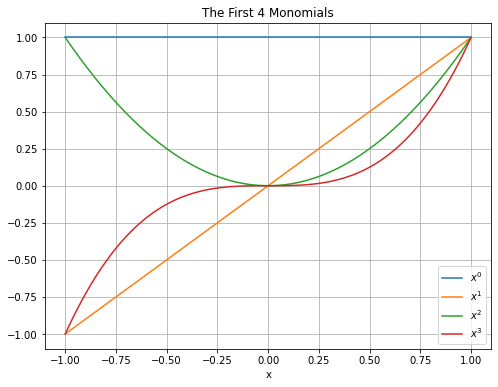

In [9]:
x = numpy.linspace(-1,1,100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
for n in range(4):
    axes.plot(x,x**n,label='$x^{}$'.format(n))
axes.set_xlabel('x')
axes.grid()
axes.legend(loc='best')
axes.set_title('The First 4 Monomials')
plt.show()

But more fundamentally. A set of functions is **linearly independent** if the only linear combination that add to form the zero function, e.g.

$$
    P_N(x) = p_0 1 + p_1 x + p_2 x^2 + \ldots + p_n x^n = 0
$$

is if all the coefficients $p_i = 0$, $\forall i=0,\ldots N$

**Theorem**:  The monomials $x^0,\ldots, x^n$ are linear independent.

**Proof**: consider $P_N(x) = 0$ for all $x$.  Since the polynomials (and monomials) are differentiable at least $n$ times,  differentiate $n$ times to yield 
$$
    P^{(n)}_N(x) = n!p_n = 0
$$ 
which implies $p_n=0$.  

Using  this result and differentiating $n-1$ times shows $p_{n-1}=0$, which by induction gives all $p_i = 0$.

Put another way,  the only $n$th degree polynomial that is zero everywhere is if all coefficients are zero.

#### The Fundamental theorem of algebra

Every $n$th degree polynomial has exactly  $n$ complex roots, i.e. 

$$
    P_N(x) = (x - a_1)(x - a_2)\ldots(x - a_n)
$$

for $a_i\in \mathbb{C}$.  Therefore, a _non-trivial_ $n$th order polynomial can only be zero at at most $n$ points.

### Proof - Uniqueness of Polynomial Interpolants

Let 

$$\mathcal{P}_N(x) = \sum^N_{n=0} p_n x^n $$

**interpolate** the $N+1$ points $y_i$ at $x_i$.

i.e. 
$$
    \mathcal{P}_N(x_i) = y_i,\quad \mathrm{for}\quad i=0,1,\ldots,N
$$
and $x_i \neq x_j ~~~ \forall i,j$.

Assume there exists another polynomial 

$$Q_N(x) = \sum^N_{n=0} q_n x^n$$

that passes through the same set of points such that $Q_N(x_i) = y_i$.  Now compute $T_N(x) = \mathcal{P}_N(x) - Q_N(x)$:

Now, by construction,  $T_N(x_i) = 0$ which implies that it is equal to zero at $n+1$ points.  However, 

$$T_N(x) = \mathcal{P}_N(x) - Q_N(x) = \sum^N_{n=0} p_n x^n - q_n x^n = \sum^N_{n=0} (p_n - q_n) x^n$$

is a $n$th order polynomial which has at most $n$ real roots.  The only way to reconcile this is if $T_n(x) = 0$, *for all* $x$, and therefore $p_n - q_n = 0$ individually and therefore $\mathcal{P}_N(x) = Q_N(x)$.

#### Example 3:  Monomial Basis

Consider $\mathcal{P}_3(x) = p_0 + p_1 x + p_2 x^2 + p_3 x^3$ with the four data points $(x_i, y_i), ~~ i = 0,1,2,3$.  We have four equations and four unknowns as expected:

$$\mathcal{P}_3(x_0) = p_0 + p_1 x_0 + p_2 x_0^2 + p_3 x_0^3 = y_0$$

$$\mathcal{P}_3(x_1) = p_0 + p_1 x_1 + p_2 x_1^2 + p_3 x_1^3 = y_1$$

$$\mathcal{P}_3(x_2) = p_0 + p_1 x_2 + p_2 x_2^2 + p_3 x_2^3 = y_2$$

$$\mathcal{P}_3(x_3) = p_0 + p_1 x_3 + p_2 x_3^2 + p_3 x_3^3 = y_3$$

Lets rewrite these as a matrix equation: First define the following vectors

$$\mathbf{x} = \begin{bmatrix} x_0 \\ x_1 \\ x_2 \\ x_3 \end{bmatrix} \quad \mathbf{y} = \begin{bmatrix} y_0 \\ y_1 \\ y_2 \\ y_3 \end{bmatrix} \quad \mathbf{p} = \begin{bmatrix} p_0 \\ p_1 \\ p_2 \\ p_3 \end{bmatrix}$$

When we write the system in matrix/vector form the matrix that arises is called a *Vandermonde* matrix:

$$
V = \begin{bmatrix} 
     1 & x_0 & x_0^2 & x_0^3 \\
     1 & x_1 & x_1^2 & x_1^3 \\
     1 & x_2 & x_2^2 & x_2^3 \\
     1 & x_3 & x_3^2 & x_3^3
\end{bmatrix}.
$$

We can now write the system of linear equations 


$$\mathcal{P}_3(x_0) = p_0 + p_1 x_0 + p_2 x_0^2 + p_3 x_0^3 = y_0$$

$$\mathcal{P}_3(x_1) = p_0 + p_1 x_1 + p_2 x_1^2 + p_3 x_1^3 = y_1$$

$$\mathcal{P}_3(x_2) = p_0 + p_1 x_2 + p_2 x_2^2 + p_3 x_2^3 = y_2$$

$$\mathcal{P}_3(x_3) = p_0 + p_1 x_3 + p_2 x_3^2 + p_3 x_3^3 = y_3$$

as $V(\mathbf{x}) \mathbf{p} = \mathbf{y}$:

$$\begin{bmatrix} 
     1 & x_0 & x_0^2 & x_0^3 \\
     1 & x_1 & x_1^2 & x_1^3 \\
     1 & x_2 & x_2^2 & x_2^3 \\
     1 & x_3 & x_3^2 & x_3^3
\end{bmatrix} \begin{bmatrix} p_0 \\ p_1 \\ p_2 \\ p_3 \end{bmatrix} = \begin{bmatrix} y_0 \\ y_1 \\ y_2 \\ y_3 \end{bmatrix}.$$

**Note**: the columns  of $V$ are simply the monomial functions sampled at the discrete points $x_i$. i.e $V_j = \mathbf{x}^j$.

Because the monomials are linearly independent, so are the columns of $V$

$$\begin{bmatrix} 
     1 & x_0 & x_0^2 & x_0^3 \\
     1 & x_1 & x_1^2 & x_1^3 \\
     1 & x_2 & x_2^2 & x_2^3 \\
     1 & x_3 & x_3^2 & x_3^3
\end{bmatrix} \begin{bmatrix} p_0 \\ p_1 \\ p_2 \\ p_3 \end{bmatrix} = \begin{bmatrix} y_0 \\ y_1 \\ y_2 \\ y_3 \end{bmatrix}$$

- What happens if we have redundant data?  Either $(x_i, y_i)$ is repeated or for one $i$ we have two values of $y$.
- What if we have more points then the order of polynomial we want?
- How does this relate to solving the above linear system of equations?

Vandermonde matrices in general are defined as

$$V = \begin{bmatrix} 
    1      & x_0    & x_0^2  & \cdots & x_0^N  \\
    1      & x_1    & x_1^2  & \cdots & x_1^N  \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1      & x_m    & x_m^2  & \cdots & x_m^N  \\
\end{bmatrix}
$$

where $V$ is a $m \times n$ matrix with points $(x_i, y_i)$ for $i = 0, 1, 2, 3, \ldots m$ and for an order $N$ polynomial $\mathcal{P}_N(x)$.

### Finding $p_i$

Finding the coefficients of $\mathcal{P}_N(x)$ can be done by solving the system outlined above.  There are functions in `numpy` that can do this for us such as:
 - `numpy.polyfit(x, y, x.shape[0] - 1)`
 - `numpy.vander(x, N=None)` to construct the matrix and use a linear solver routine.

We can also use a different **basis** that might be easier to use.

### Basis

**Def:**  A basis for a $N$ dimensional vector space is a set of linearly independent vectors that span the space.

The monomials,  $1,x,\ldots, x^n$, form the usual basis for the vector space of $n$th degree polynomials $P_N(x)$. 

**Example** $P_2(x)$ is the space of all quadratic functions. i.e. $P_2(x) = \mathrm{span}< 1,x,x^2>$

$$
    P_2(x) = p_0 + p_1 x + p_2 x^2
$$

i.e for every vector $\mathbf{p}\in\mathbb{R}^3$, there is a unique quadratic function in $P_2(x)$.  (we say $P_2$ is *isomorphic* to $\mathbb{R}^3$ and is a three dimensional function space).

**However**,  the monomials are not the only basis for $P_N$

### Lagrange Basis

Given $N+1$ points $(x_0,y_0), (x_1,y_1), \ldots, (x_{N},y_{N})$ again assuming the $x_i$ are all unique, the interpolating polynomial $\mathcal{P}_N(x)$ can also be written as

$$\mathcal{P}_N(x) = \sum^{N}_{i=0} y_i \ell_i(x)$$

where 

$$\ell_i(x) = \prod^{N}_{j=0, j \neq i} \frac{x - x_j}{x_i - x_j} = \frac{x - x_0}{x_i - x_0} \frac{x - x_1}{x_i - x_1} \cdots \frac{x - x_{i-1}}{x_i - x_{i-1}}\frac{x - x_{i+1}}{x_i - x_{i+1}} \cdots \frac{x - x_{N}}{x_i - x_{N}}$$

are the **Lagrange Polynomials**

### Lagrange Polynomials

$$\ell_i(x) = \prod^{N}_{j=0, j \neq i} \frac{x - x_j}{x_i - x_j} $$

A Key property of the Lagrange polynomials is that 

$$
    \ell_i(x_j) = \delta_{ij} = \left\{\begin{matrix}
            0 & i\neq j \\ 
            1 & i=j\\
            \end{matrix}\right.
$$
which is why the weights in $P_N(x)$ are simply the $y$ values of the interpolant

### Visualizing the Lagrange Polynomials

In [10]:

# ====================================================
# Compute the Lagrange basis (\ell_i(x))
def lagrange_basis(x, data):
    """Compute Lagrange basis at x given N data points
    
    params:
    -------
        x: ndarray
            1-d Array of floats
        data: ndarray of shape (N,2)
            2-d Array of data where each row is [ x_i, y_i ]
    returns:
    --------
        basis: ndarray of shape (N, x.shape)
            : 2-D array of lagrange basis functions evaluated at x
            
    """
    basis = numpy.ones((data.shape[0], x.shape[0]))
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if i != j:
                basis[i, :] *= (x - data[j, 0]) / (data[i, 0] - data[j, 0])
    return basis

In [12]:
# ====================================================
# Calculate full polynomial
def poly_interpolant(x, data):
    """Compute polynomial interpolant of (x,y) using Lagrange basis"""
    P = numpy.zeros(x.shape[0])
    basis = lagrange_basis(x, data)
    for n in range(data.shape[0]):
        P += basis[n, :] * data[n, 1]
    return P

# ====================================================

In [25]:
x_data = numpy.array([0., 1., 2.])
#x_data = numpy.array([0., 1., 2., 3.])
y_data = numpy.ones(x_data.shape)

data = numpy.array([x_data, y_data]).T
x = numpy.linspace(x_data.min(),x_data.max(),100)
basis = lagrange_basis(x, data)

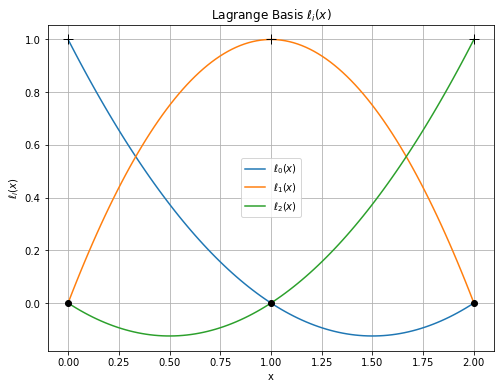

In [26]:
# ====================================================
# Plot individual basis functions

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
basis = lagrange_basis(x, data)
for i in range(len(x_data)):
    axes.plot(x, basis[i, :], label="$\ell_{%s}(x)$" % i)
axes.plot(x_data,numpy.zeros(x_data.shape),'ko')
axes.plot(x_data,y_data,'k+',markersize=10)

axes.set_title("Lagrange Basis $\ell_i(x)$")
axes.set_xlabel("x")
axes.set_ylabel("$\ell_i(x)$")
axes.grid()
axes.legend(loc='best')
plt.show()

### Solving for the coefficients of $P_N(x)$

In general,   if 

$$
    P_N(x) = \sum_{j=0}^N w_j\phi_j(x)
$$
where $\phi_j(x)$ is any basis function for $P_N$ (i.e. monomial, Lagrange, and there are many more). Then finding the unique set of weights for the interpolating polynomial through $N+1$ distinct data points $(x_i, y_i)$, just reduces to solving $N+1$ linear equations $P_N(x_i) = y_i$.  

For the monomial basis this reduces to the linear system

$$
    V(\mathbf{x})\mathbf{w} = \mathbf{y}
$$

What is the matrix $V$, for the Lagrange Basis?  What are the weights $\mathbf{w}$?

A little pen-and-paper work here can be instructive$\ldots$

### Linear Independence of the Lagrange Polynomials

Because the weights of each basis function in the Lagrange basis is just the $y$ value at the interpolation points,  it is straightforward to show that the Lagrange polynomials are linearly independent.  I.e. the statement 

$$
    \sum_{n=0}^N w_j\phi_j(x) =0
$$
is equivalent to interpolating the zero function,  where all the $w_j =0$

#### Example :  $N = 1$ 1st order general Lagrange Polynomial as linear interpolant

Given 2 points $(x_0, y_0)$ and $(x_1, y_1)$ the Lagrange form of $\mathcal{P}_N(x)$ is given by

$$\ell_0(x) = \frac{x - x_1}{x_0 - x_1}$$

and

$$\ell_1(x) = \frac{x - x_0}{x_1 - x_0}$$

and the 1st order interpolating Polynomial is simply

$$\mathcal{P}_1(x) = y_0\ell_0(x)+ y_1\ell_1(x)$$

The behavior of $\mathcal{P}_1(x)$ becomes clearer if we note that on the interval $x\in[x_0,x_1]$ that 

$$
\ell_1(x) = \frac{x- x_0}{x_1 - x_0} = s
$$ 
is simply the fractional distance across the interval.
    

We should also note that 

$$
\begin{align}
    \ell_0(x) &= \frac{x - x_1}{x_0 - x_1}\\
    &= 1-\ell_1(x) \\
    &= 1-s\\
    \end{align}
$$ 

(show this)

Then the interpolating polynomial is simply
$$
\begin{align}
\mathcal{P}_1(s) &= y_0(1-s) + y_1 s \\&= y_0 + s(y_1 - y_0)
\end{align}
$$

for $s\in[0,1]$ which is just the linear line segment that connects points $y_0$ and $y_1$

As a specific example we will plot $\ell_0(x)$, $\ell_1(x)$ and $\mathcal{P}_1$ for the interval 
$x=[1,3]$  and $y_0=2$, $y_1=3$

In [31]:
x0, y0 = (1., 2.)
x1, y1 = (3., 3.)
ell0 = lambda x: (x - x1)/(x0 - x1)
ell1 = lambda x: (x - x0)/(x1 - x0)
P1 = lambda x:  y0*ell0(x) + y1*ell1(x)

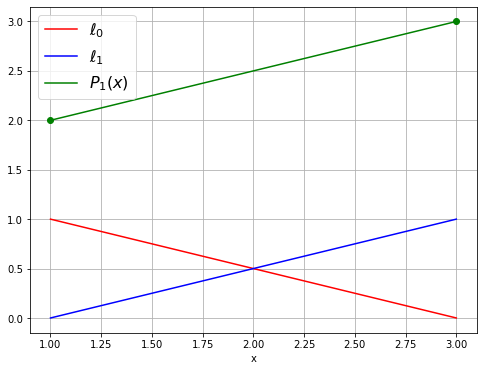

In [32]:
x = numpy.linspace(x0,x1)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(x,ell0(x),'r',label='$\ell_0$')
axes.plot(x,ell1(x),'b',label='$\ell_1$')
axes.plot(x,P1(x),'g',label='$P_1(x)$')
axes.plot((x0,x1),(y0,y1),'go')
axes.set_xlabel('x')
axes.grid()
axes.legend(loc='best',fontsize=16)
plt.show()

#### Example: Interpolate four points from $\sin(2\pi x)$

Use six evenly spaced points to approximate $\sin$ on the interval $x \in [-1, 1]$.  What is the behavior as $N \rightarrow \infty$?  Also plot the absolute error between $f(x)$ and the interpolant $P_N(x)$.

In [74]:
num_points = 6

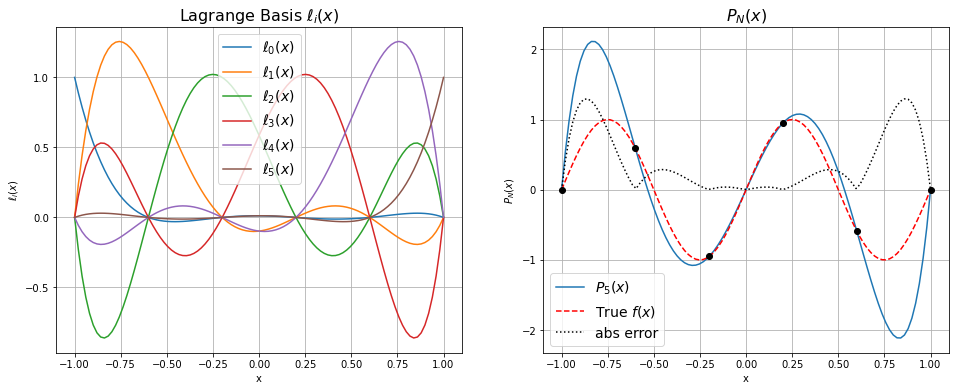

In [75]:
# num_points = 5
# num_points = 6
# num_points = 20
data = numpy.empty((num_points, 2))
data[:, 0] = numpy.linspace(-1, 1, num_points)
data[:, 1] = numpy.sin(2.0 * numpy.pi * data[:, 0])
N = data.shape[0] - 1 # Degree of polynomial
M = data.shape[0]
x = numpy.linspace(-1.0, 1.0, 100)

px = poly_interpolant(x, data)
f = numpy.sin(2.0 * numpy.pi * x)
err = numpy.abs(f - px)

# ====================================================
# Plot individual basis functions
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
basis = lagrange_basis(x, data)
for i in range(N + 1):
    axes.plot(x, basis[i, :], label="$\ell_{%s}(x)$" % i)

axes.set_title("Lagrange Basis $\ell_i(x)$",fontsize=16)
axes.set_xlabel("x")
axes.set_ylabel("$\ell_i(x)$")
axes.legend(loc='best',fontsize=14)
axes.grid()

# Plot full polynomial P_N(x)
axes = fig.add_subplot(1, 2, 2)
axes.plot(x, px , label="$P_{%s}(x)$" % N)
axes.plot(x, numpy.sin(2.0 * numpy.pi * x), 'r--', label="True $f(x)$")
axes.plot(x, err, 'k', linestyle='dotted',label='abs error')
for point in data:
    axes.plot(point[0], point[1], 'ko')
axes.set_title("$P_N(x)$",fontsize=16)
axes.set_xlabel("x")
axes.set_ylabel("$P_N(x)$")
axes.legend(loc='best',fontsize=14)
axes.grid()
    
plt.show()

#### Example 6: Runge's Function

Interpolate $f(x) = \frac{1}{1 + 25 x^2}$ using 6 points of your choosing on $x \in [-1, 1]$.

Try it with 11 points.

Keep increasing the number of points and see what happens.

In [58]:
def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

x = numpy.linspace(-1., 1., 100)
num_points = 6

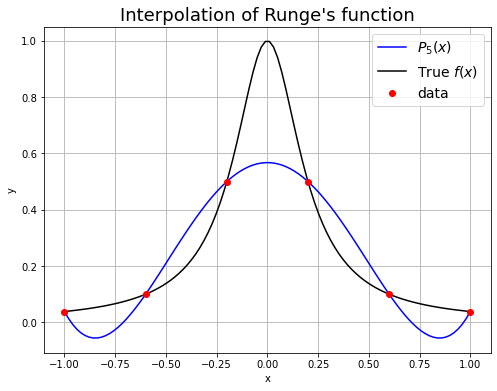

In [59]:

data = numpy.empty((num_points, 2))
data[:, 0] = numpy.linspace(-1, 1, num_points)
data[:, 1] = f(data[:, 0])
N = data.shape[0] - 1
    
# Plot the results
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, poly_interpolant(x, data), 'b', label="$P_{{{name}}}(x)$".format(name=num_points-1))
axes.plot(x, f(x), 'k', label="True $f(x)$")
axes.plot(data[:, 0], data[:, 1], 'ro', label="data")
          
axes.set_title("Interpolation of Runge's function",fontsize=18)
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.legend(loc='best',fontsize=14)
axes.grid()

plt.show()

#### Example 7: Weierstrass "Monster" Function

Defined as
$$
    f(x) = \sum^\infty_{n=0} a^n \cos(b^n \pi x)
$$
such that
$$
    0 < a < 1 \quad \text{and} \quad a b > 1 + \frac{3\pi}{2}.
$$
This function is continuous everywhere but not differentiable anywhere.

In [ ]:
def f(x, a=0.9, N=100):
    summation = 0.0
    b = (1.0 + 3.0 / 2.0 * numpy.pi) / a + 0.01
    print(b)
    for n in range(N + 1):
        summation += a**n * numpy.cos(b**n * numpy.pi * x)
    return summation

x = numpy.linspace(-1, 1, 1000)
# x = numpy.linspace(-2, 2, 100)

num_points = 10
data = numpy.empty((num_points, 2))
data[:, 0] = numpy.linspace(-1, 1, num_points)
data[:, 1] = f(data[:, 0])
N = data.shape[0] - 1
    
# Plot the results
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, poly_interpolant(x, data), 'b', label="$P_6(x)$")
axes.plot(x, f(x), 'k', label="True $f(x)$")
axes.plot(data[:, 0], data[:, 1], 'ro', label="data")
          
axes.set_title("Interpolation of Runge's function")
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.legend(loc=1)

plt.show()

### Rules of Thumb

 - Avoid high-order interpolants when possible!  Keep increasing the number of points and see what happens.
 - Avoid extrapolation - Increase the range of $x$ in the above example and check how good the approximation is beyond our sampling interval

### Error Analysis

**Theorem:** Lagrange Remainder Theorem - Let $f(x) \in C^{N+1}[-1, 1]$, then

$$
    f(x) = \mathcal{P}_N(x) + R_N(x)
$$

where $\mathcal{P}_N(x)$ is the interpolating polynomial and

$$
    R_N(x) = Q(x) \frac{f^{(N+1)}(c)}{(N+1)!} \quad \text{with} \quad c \in [-1,1]
$$
where
$$
    Q(x) = \prod^N_{i=0} (x - x_i) = (x-x_0)(x-x_1)\cdots(x-x_N) .
$$

is a *monic* polynomial of order $N+1$ with exactly $N+1$ roots at the nodes $x_i$

A few things to note:
 - For Taylor's theorem note that $Q(x) = (x - x_0)^{N+1}$ and the error only vanishes at $x_0$.
 - For Lagrange's theorem the error vanishes at all $x_i$.
 - To minimize $R_N(x)$ requires minimizing $|Q(x)|$ for $x \in [-1, 1]$.

#### Minimizing $R_N(x)$

Minimizing the error $R_N(x)$ in Lagrange's theorem is equivalent to minimizing $|Q(x)|$ for $x \in [-1, 1]$.

Minimizing error $\Leftrightarrow$ picking roots of $Q(x)$ or picking the points where the interpolant data is located.  How do we this?

### Chebyshev Polynomials

*Chebyshev polynomials* $T_N(x)$ are another basis that can be used for interpolation.

First 5 polynomials
$$T_0(x) = 1$$

$$T_1(x) = x$$

$$T_2(x) = 2 x^2 - 1$$

$$T_3(x) = 4 x^3 - 3 x$$

$$T_4(x) = 8x^4 - 8x^2 + 1$$

In general,  the Chebyshev polynomials are generated by a recurrence relation 

$$T_k(x) = 2 x T_{k-1}(x) - T_{k-2}(x)$$

In [76]:
def cheb_poly(x, N):
    """Compute the *N*th Chebyshev polynomial and evaluate it at *x*"""
    T = numpy.empty((3, x.shape[0]))
    T[0, :] = numpy.ones(x.shape)
    T[1, :] = x
    if N == 0:
        return T[0, :]
    elif N == 1:
        return T[1, :]
    else:
        for k in range(2, N + 1):
            T[2, :] = 2.0 * x * T[1, :] - T[0, :]
            T[0, :] = T[1, :]
            T[1, :] = T[2, :]
    
        return T[2, :]

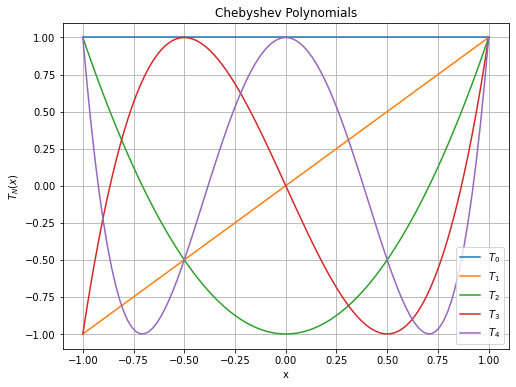

In [77]:
x = numpy.linspace(-1, 1, 100)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

for n in range(5):
    axes.plot(x, cheb_poly(x, n), label="$T_%s$" % n)

axes.set_ylim((-1.1, 1.1))
axes.set_title("Chebyshev Polynomials")
axes.set_xlabel("x")
axes.set_ylabel("$T_N(x)$")
axes.legend(loc='best')
axes.grid()

plt.show()

#### Chebyshev nodes

Chebyshev polynomials have many special properties and locations including the location of their roots and extrema known as Chebyshev nodes


* Chebyshev nodes of the 1st kind (roots)

$$
    x_k = \cos \left (\frac{(2 k - 1) \pi}{2 N} \right ) \quad k = 1, \ldots, N
$$

* Chebyshev nodes of the 2nd kind (extrema)

$$
    x_k = \cos \left( \frac{k \pi}{N} \right) \quad k = 0, \ldots, N
$$



In [78]:
N = 6  
x_extrema = numpy.cos(numpy.arange(N + 1) * numpy.pi / N)
x_nodes = numpy.cos((2.0 * numpy.arange(1, N + 1) - 1.0) / (2.0 * N) * numpy.pi)

Nodes   = [-0.96592583 -0.70710678 -0.25881905  0.25881905  0.70710678  0.96592583]
Extrema = [-1.00000000e+00 -8.66025404e-01 -5.00000000e-01  6.12323400e-17
  5.00000000e-01  8.66025404e-01  1.00000000e+00]


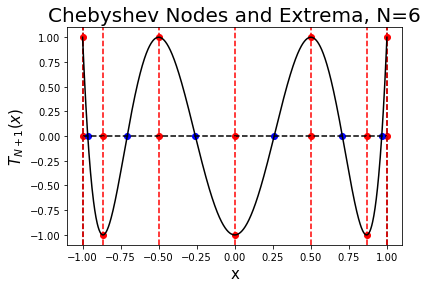

In [79]:
fig = plt.figure()
# fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 1, 1)

# Plot points
axes.plot(x_extrema, numpy.zeros(N+1), 'ro')
axes.plot(x_nodes, numpy.zeros(N), 'bo')
    
# Plot some helpful lines
axes.plot((-1.0, -1.0), (-1.1, 1.1), 'k--')
axes.plot((1.0, 1.0), (-1.1, 1.1), 'k--')
axes.plot((-1.0, 1.0), (0.0, 0.0), 'k--')
for i in range(x_extrema.shape[0]):
    axes.plot((x_extrema[i], x_extrema[i]), (-1.1, 1.1), 'r--')
    axes.plot(x_extrema[i], cheb_poly(x_extrema, N)[i], 'ro')

print('Nodes   = {}'.format(numpy.sort(x_nodes)))
print('Extrema = {}'.format(numpy.sort(x_extrema)))
#print(numpy.cos(x_extrema))
    
# Plot Chebyshev polynomial
x_hat = numpy.linspace(-1, 1, 1000)
axes.plot(x_hat, cheb_poly(x_hat, N), 'k')
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))

# Labels
axes.set_title("Chebyshev Nodes and Extrema, N={}".format(N), fontsize="20")
axes.set_xlabel("x", fontsize="15")
axes.set_ylabel("$T_{N+1}(x)$", fontsize="15")

plt.show()

In [ ]:
# First-kind Nesting (3 x)
fig = plt.figure()
# fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 1, 1)

N = 5
factor = 3
x_1 = numpy.cos((2.0 * numpy.arange(1, N + 1) - 1.0) / (2.0 * N) * numpy.pi)
x_2 = numpy.cos((2.0 * numpy.arange(1, factor * N + 1) - 1.0) / (2.0 * factor * N) * numpy.pi)

axes.plot(x_1, numpy.zeros(N), "o", color="r", markerfacecolor="lightgray", markersize="15")
axes.plot(x_2, numpy.zeros(N * factor), 'kx', markersize="10")

x_hat = numpy.linspace(-1, 1, 1000)
axes.plot(x_hat, cheb_poly(x_hat, N), 'k')
axes.plot(x_hat, cheb_poly(x_hat, factor * N), 'k')
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.set_title("Nesting of 1st and 2nd Kind Chebyshev Polynomials")
axes.set_xlabel("$x$")
axes.set_ylabel("$T_N(x)$")
plt.show()

#### Properties of Chebyshev Polynomials
1. Defined by a recurrence relation 
   $$ T_0(x) = 1,\quad T_1(x) = x$$
   $$T_k(x) = 2 x T_{k-1}(x) - T_{k-2}(x),\quad k\geq2$$

2. Leading coefficient of $x^N$ in $T_N(x)$ is $2^{N-1}$ for $N \geq 1$

3. Extreme values:

   $$|T_N(x)| \leq 1 \quad \text{for} \quad  -1 \leq x \leq 1$$
 

#### Properties of Chebyshev Polynomials
4. Minimax principle:  The polynomial

   $$T(x) = \frac{T_{N+1}(x)}{2^N}$$
   
   is a *monic polynomial*, a univariate function with the leading coefficient equal to 1, with the property that
   
   $$
       \max |T(x)| \leq \max |Q(X)| \quad \text{for} \quad  x \in [-1, 1], \quad \text{and}
   $$
   $$
       \max |T(x)| = \frac{1}{2^N}
   $$
   
  

 Recall that the remainder term in the Lagrange Remainder Theorem was
   $$
        R_N(x) = Q(x) \frac{f^{(N+1)}(c)}{(N+1)!} \quad \text{with} \quad c \in [-1,1]
   $$
   with
   $$
        Q(x) = \prod^N_{i=0} (x - x_i) = (x-x_0)(x-x_1)\cdots(x-x_N) .
   $$

#### Error Analysis Redux

Given that the Chebyshev polynomials are a minimum on the interval $[-1, 1]$ we would like $Q(x) = T(x)$.  

Since we only know the roots of $Q(x)$ (the points where the interpolant data is located) we require these points to be the roots of the Chebyshev polynomial $T_{N+1}(x)$ therefore enforcing $T(x) = Q(x)$.

The zeros of $T_N(x)$ in the interval $[-1, 1]$ can be shown to satisfy
$$
    x_k = \cos\left( \frac{(2k - 1) \pi}{2 N} \right ) \quad \text{for} \quad k=1, \ldots, N
$$
These nodal points (sampling the function at these points) can be shown to minimize interpolation error.

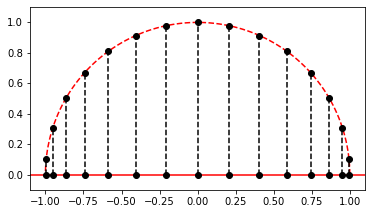

In [80]:
x = numpy.linspace(0, numpy.pi, 100)
N = 15

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, aspect="equal")

axes.plot(numpy.cos(x), numpy.sin(x), 'r--')
axes.plot(numpy.linspace(-1.1, 1.1, 100), numpy.zeros(x.shape), 'r')
for k in range(1, N + 1):
    location = [numpy.cos((2.0 * k - 1.0) * numpy.pi / (2.0 * N)),
                numpy.sin((2.0 * k - 1.0) * numpy.pi / (2.0 * N))]
    axes.plot(location[0], location[1], 'ko')
    axes.plot(location[0], 0.0, 'ko')
    axes.plot([location[0], location[0]], [0.0, location[1]], 'k--')
    
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-0.1, 1.1))
plt.show()

#### Summary

1. Minimizing the error in Lagrange's theorem is equivalent to minimizing 
$$
    |Q(x)| \quad \text{for} \quad x \in [-1, 1].
$$
1. We know Chebyshev polynomials are a minimum on the interval $[-1, 1]$ so we would like to have $Q(x)=T(x)$.
1. Since we only know the roots of $Q(x)$ (the points where the interpolant data is located) we require these points to be the roots of the Chebyshev polynomial $T_{N+1}(x)$ therefore enforcing $T(x) = Q(x)$.
1. The zeros of $T_N(x)$ in the interval $[-1, 1]$ can be shown to satisfy
$$
    x_k = \cos\left( \frac{(2k - 1) \pi}{2 N} \right ) \quad \text{for} \quad k=1, \ldots, N
$$
These nodal points (sampling the function at these points) can be shown to minimize interpolation error.

#### Notes
 - The Chebyshev nodes minimize interpolation error for any polynomial basis (due to uniqueness of the interpolating polynomial, any polynomial that interpolates these points are identical regardless of the basis).
 - Chebyshev nodes uniquely define the Chebyshev polynomials.
 - The boundedness properties of Chebyshev polynomials are what lead us to the roots as a minimization but there are other uses for these orthogonal polynomials.
 - There are two kinds of Chebyshev nodes and therefore two definitions.

### Example:  Chebyshev Interpolation of Runge's function

Comparison between interpolation at Chebyshev Nodes vs equally spaced points

In [91]:
# Runge's function again 
def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# Parameters
x = numpy.linspace(-1., 1., 100)
num_points = 7

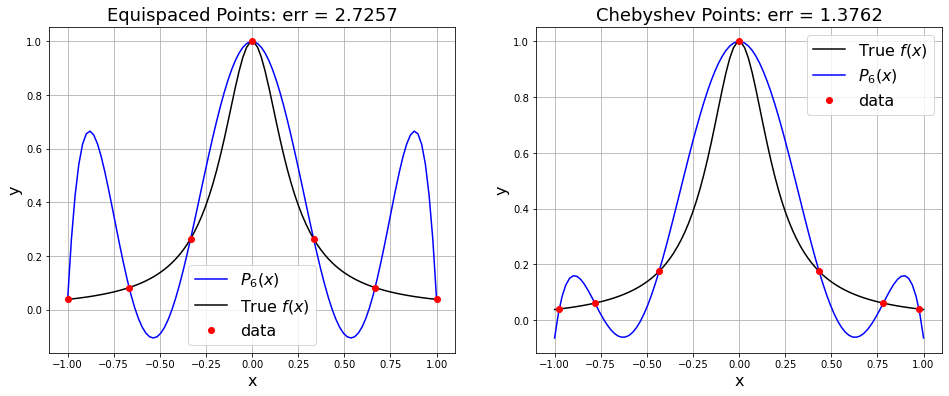

In [92]:
# ============================================================
#  Equidistant nodes
equidistant_data = numpy.empty((num_points, 2))
equidistant_data[:, 0] = numpy.linspace(-1, 1, num_points)
equidistant_data[:, 1] = f(equidistant_data[:, 0])
N = equidistant_data.shape[0] - 1

P_lagrange = poly_interpolant(x, equidistant_data)

# ============================================================
#  Chebyshev nodes
chebyshev_data = numpy.empty((num_points, 2))
chebyshev_data[:, 0] = numpy.cos((2.0 * numpy.arange(1, num_points + 1) - 1.0) * numpy.pi / (2.0 * num_points))
chebyshev_data[:, 1] = f(chebyshev_data[:, 0])

P_cheby1 = poly_interpolant(x, chebyshev_data)
    
# Fit directly with Chebyshev polynomials
coeff = numpy.polynomial.chebyshev.chebfit(chebyshev_data[:, 0], chebyshev_data[:, 1], N)
P_cheby2 = numpy.polynomial.chebyshev.chebval(x, coeff)

# Check on unique polynomials
#print(numpy.allclose(P_cheby1, P_cheby2))

# calculate errornorms for different interpolants
equidistant_err = numpy.linalg.norm(P_lagrange - f(x))
cheb_err = numpy.linalg.norm(P_cheby1 - f(x))

# ============================================================
# Plot the results
fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(hspace=.5)

axes = fig.add_subplot(1, 2, 1)
axes.plot(x, P_lagrange, 'b', label="$P_%s(x)$" % N)
axes.plot(x, f(x), 'k', label="True $f(x)$")
axes.plot(equidistant_data[:, 0], equidistant_data[:, 1], 'ro', label="data")
axes.set_title("Equispaced Points: err = {:5.5g}".format(equidistant_err),fontsize=18)
axes.set_xlabel("x",fontsize=16)
axes.set_ylabel("y",fontsize=16)
axes.grid()
axes.legend(loc=8,fontsize=16)
#print('Equispaced error = {}'.format(numpy.linalg.norm(P_lagrange - f(x))))

axes = fig.add_subplot(1, 2, 2)
axes.plot(x, f(x), 'k', label="True $f(x)$")
axes.plot(x, P_cheby1, 'b', label="$P_%s(x)$" % N)
axes.plot(chebyshev_data[:, 0], chebyshev_data[:, 1], 'ro', label="data")
          
axes.set_title("Chebyshev Points: err = {:5.5g}".format(cheb_err),fontsize=18)
axes.set_xlabel("x",fontsize=16)
axes.set_ylabel("y",fontsize=16)
axes.legend(loc=1,fontsize=16)
axes.grid()
#print('Chebyshev error = {}'.format(numpy.linalg.norm(P_cheby1 - f(x))))


plt.show()

### Affine Transformation of intervals

While the chebyshev polynomials (and their roots) are defined on the interval 
$$
    s \in[-1, 1]
$$ 

it turns out we can use them to approximate functions on any arbitrary interval $x\in[a,b]$ as long as we can map the interval $[-1,1]$ onto $[a,b]$.   This is easy to do given the  *affine transformation*

$$
    x(s) = \alpha + \beta s
$$

defined by a scaling $\beta$ and a shift $\alpha$

To solve for $\alpha$ and $\beta$, we simply transform the two endpoints such that
$$
\begin{align}
    x(-1) &= \alpha - \beta  = a \\
    x(1) &= \alpha + \beta  = b \\
\end{align}
$$

or

$$
    \begin{bmatrix} 1 & -1 \\ 1 & 1\end{bmatrix}\begin{bmatrix} \alpha \\ \beta \end{bmatrix}=\begin{bmatrix} a \\ b \end{bmatrix}
$$



or solving

$$
    \begin{align}
        \alpha &= \frac{a+b}{2} \\
        \beta &= \frac{b -a}{2}\\
        \end{align}
$$



### Affine Transformation of intervals

Thus if we know the Chebyshev nodes in $s$
$$
    s_k = \cos\left( \frac{(2k - 1) \pi}{2 N} \right ) \quad \text{for} \quad k=1, \ldots, N
$$ 

then the correct interpolation points on $[a,b]$ are simply $x_k = x(s_k)$

For example:  if $s_k=0$ (in the center of the interval), then 

$$x_k = x(0) = \frac{a+b}{2}$$

### Note

Affine Transformation of the interval is useful for may problems and applications.

## Piece-Wise Polynomial Interpolation

Given $N$ points, use lower order polynomial interpolation to fit the function in pieces.  We can choose the order of the polynomials and the continuity.

 - $C^0$: Interpolant is continuous
   - Linear interpolation
   - Quadratic interpolation
 - $C^1$: Interpolation and 1st derivative are continuous
   - Cubic Hermite polynomials (PCHiP)
 - $C^2$: Interpolation, 1st and 2nd derivatives are continuous 
   - Cubic splines

### Piece-Wise Linear

Given a segment between point $(x_k, y_k)$a nd $(x_{k+1}, y_{k+1})$ define the segment as

$$\mathcal{P}_k(x) = \frac{y_{k+1} - y_k}{x_{k+1} - x_k} (x - x_k) + y_k$$

The final interpolant $\mathcal{P}(x)$ is then defined on $[x_k, x_{k+1}]$ using this function.

In [93]:
data = numpy.array([[1.0, 3.0], [2.0, 1.0], [3.5, 4.0], [5.0, 0.0], [6.0, 0.5], [9.0, -2.0], [9.5, -3.0]])
x = numpy.linspace(0.0, 10, 100)
N = data.shape[0] - 1

# Lagrange Basis
P_lagrange = poly_interpolant(x, data)

# C^0 Piece-wise linear
# P_pw_linear = numpy.interp(x, data[:, 0], data[:, 1])
P_linear = numpy.zeros(x.shape)
for n in range(1, N + 1):
    P_linear += ((data[n, 1] - data[n - 1, 1]) / (data[n, 0] - data[n - 1, 0]) * (x - data[n - 1, 0]) 
                         + data[n - 1, 1]) * (x > data[n - 1, 0]) * (x <= data[n, 0])
                 

In [ ]:
# Add end points for continuity
P_linear += numpy.ones(x.shape) * data[0, 1] * (x < data[0, 0])
P_linear += numpy.ones(x.shape) * data[-1, 1] * (x >= data[-1, 0])

# Plot
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(data[:,0], data[:,1], 'ko')
axes.plot(x, P_lagrange, 'b--',label='$P_{{{name}}}$'.format(name=N))
axes.plot(x, P_linear, 'r',label='Piecewise Linear')

axes.set_title("Interpolated Data - $C^0$ Linear",fontsize=18)
axes.set_xlabel("x",fontsize=16)
axes.set_ylabel("$P_1(x)$",fontsize=16)
axes.set_xlim([0.0, 10.0])
axes.set_ylim([-4.0, 15.0])
axes.legend(loc='best',fontsize=14)
axes.grid()

plt.show()

### Piece-Wise Quadratic $C^0$ Polynomials

Use every three points $(x_{k+1}, y_{k+1})$, $(x_{k}, y_{k})$, and $(x_{k-1}, y_{k-1})$, to find quadratic interpolant and define final interpolant $P(x)$ using the quadratic interpolant $\mathcal{P}_k(x)$ on $[x_{k-1}, x_{k+1}]$.

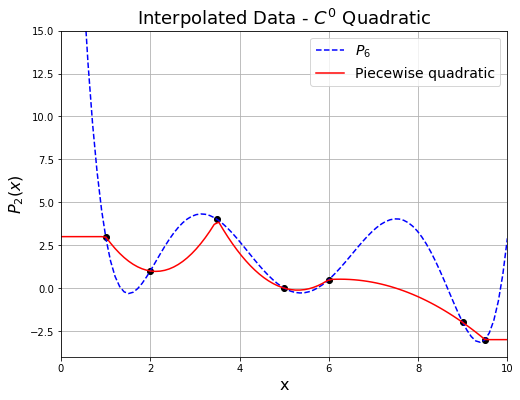

In [95]:
data = numpy.array([[1.0, 3.0], [2.0, 1.0], [3.5, 4.0], [5.0, 0.0], [6.0, 0.5], [9.0, -2.0], [9.5, -3.0]])
x = numpy.linspace(0.0, 10, 100)
N = data.shape[0] - 1

# This isn't overlapping, it's more like C_0 P_2
# C^0 Piece-wise quadratic
P_quadratic = numpy.zeros(x.shape)
for k in range(1, N + 1, 2):
    p = numpy.polyfit(data[k - 1:k + 2, 0], data[k - 1:k + 2, 1], 2)
    P_quadratic += numpy.polyval(p, x) * (x > data[k - 1, 0]) * (x <= data[k + 1, 0])
# Add end points for continuity
P_quadratic += numpy.ones(x.shape) * data[0, 1] * (x < data[0, 0])
P_quadratic += numpy.ones(x.shape) * data[-1, 1] * (x >= data[-1, 0])
    
# Plot
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(data[:,0], data[:,1], 'ko')
axes.plot(x, P_lagrange, 'b--',label='$P_{{{name}}}$'.format(name=N))
axes.plot(x, P_quadratic, 'r',label='Piecewise quadratic')

axes.set_title("Interpolated Data - $C^0$ Quadratic",fontsize=18)
axes.set_xlabel("x",fontsize=16)
axes.set_ylabel("$P_2(x)$",fontsize=16)
axes.set_xlim([0.0, 10.0])
axes.set_ylim([-4.0, 15.0])
axes.legend(loc='best',fontsize=14)
axes.grid()

plt.show()

### Transformation of intervals

The previous algorithms are quite direct but can look a bit messy because every interval (or set of points) appears different...An important trick that is used in finite-element analysis is to transform each interval (or element) 

$$
    x \in[x_k, x_{k+1}]
$$ 

to the unit interval

$$
    s \in [0,1]
$$

by the affine transformation

$$ x(s) = x_k + s(x_{k+1} - x_k)$$

and do all the interpolation in the transformed frame.

### Example: Linear Interpolation

for Linear interpolation over an arbitrary interval $[x_k, x_{k+1}]$ we can use a Lagrange interpolant

$$
    P_k(x) = y_k\ell_0(x) + y_{k+1}\ell_1(x)
$$

where 
$$ 
    \ell_0(x) = \frac{x - x_{k+1}}{x_k - x_{k+1}},~\quad~  \ell_1(x) = \frac{x - x_{k}}{x_{k+1} - x_{k}}
$$

and do all the interpolation in the transformed frame.

Substituting 
$$ x(s) = x_k + s(x_{k+1} - x_k)$$

into the definitions of $\ell_0(x)$ and $\ell_1(x)$ show that within this element

$$
    \ell_0(s) = 1-s,~\quad~\ell_1(s) = s
$$

and 
$$
    P_k(s) = y_k(1-s)  + y_{k+1}s
$$


In [ ]:
xk = [ .5, 1., 3., 5.]
yk = [ .5, 2., 2.5, 1. ]
ell0 = lambda x: (x - x1)/(x0 - x1)
ell1 = lambda x: (x - x0)/(x1 - x0)
P1 = lambda x:  y0*ell0(x) + y1*ell1(x)

x = numpy.linspace(x0,x1)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(x,ell0(x),'r',label='$\ell_0$')
axes.plot(x,ell1(x),'b',label='$\ell_1$')
axes.plot(x,P1(x),'g',label='$P_1(x)$')
axes.plot((x0,x1),(y0,y1),'go')
axes.set_xlabel('x')
axes.set_xlim(0.,5.)
axes.grid()
axes.legend(loc='best',fontsize=16)
plt.show()

### Piece-Wise $C^1$ Cubic Interpolation

For the previous two cases we had discontinous 1st derivatives!  We can make this better by constraining the polynomials to be continuous at the boundaries of the piece-wise intervals.

Given a segment between points $(x_k, y_k)$ and $(x_{k+1}, y_{k+1})$ we want to fit a cubic function between the two points.

$$\mathcal{P}_k(x) = p_0 + p_1 x + p_2 x^2 + p_3 x^3$$

$$\mathcal{P}_k(x_k) = y_k, \quad \mathcal{P}_k(x_{k+1}) = y_{k+1}$$

Now we have 4 unknowns but only two data points!  Constraining the derivative at each interval end will lead to two new equations and therefore we can solve for the interpolant.

$$\frac{\text{d}}{\text{dx}} \mathcal{P}_k(x_k) = d_k, \quad \frac{\text{d}}{\text{dx}} \mathcal{P}_k(x_{k+1}) = d_{k+1}$$

where we need to prescribe the $d_k$'s.  Since we know the polynomial we can write these 4 equations as

$$\begin{aligned}
p_0 + p_1 x_k + p_2 x_k^2 + p_3 x_k^3 &= y_k \\
p_0 + p_1 x_{k+1} + p_2 x_{k+1}^2 + p_3 x_{k+1}^3 &= y_{k+1} \\
p_1 +  2p_2 x_k + 3 p_3 x_k^2 &= d_k \\
p_1 + 2 p_2 x_{k+1} + 3 p_3 x_{k+1}^2 &= d_{k+1}
\end{aligned}$$

Rewriting this as a system we get
$$\begin{bmatrix}
    1 & x_k & x_k^2 & x_k^3 \\
    1 & x_{k+1} & x_{k+1}^2 & x_{k+1}^3 \\
    0 & 1 & 2 x_k & 3 x_k^2 \\
    0 & 1 & 2 x_{k+1} & 3 x_{k+1}^2
\end{bmatrix} \begin{bmatrix}
p_0 \\ p_1 \\ p_2 \\ p_3
\end{bmatrix} = \begin{bmatrix}
y_k \\ y_{k+1} \\ d_k \\ d_{k+1}
\end{bmatrix}$$

A common simplification to the problem description re-parameterizes the locations of the points such that $s \in [0, 1]$ and recast the problem with $(0, y_k)$ and $(1, y_{k+1})$.  This simplifies the above system to
$$\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    1 & 1 & 1 & 1 \\
    0 & 1 & 0 & 0 \\
    0 & 1 & 2 & 3
\end{bmatrix} \begin{bmatrix}
p_0 \\ p_1 \\ p_2 \\ p_3
\end{bmatrix} = \begin{bmatrix}
y_k \\ y_{k+1} \\ d_k \\ d_{k+1}
\end{bmatrix}$$

which can be solved to find

$$\begin{aligned}
\mathcal{P}(s) &= (1-s)^2 (1 + 2s) y_k + s^2 (3 - 2 s) y_{k+1} + s (1 - s)^2 d_k - s^2 (1 - s)d_{k+1}\\
\mathcal{P}'(s) &= 6s(s-1) y_k + 6s(1-s) y_{k+1} + (s-1)(3s-1) d_k - s(3s-2) d_{k+1}\\
\mathcal{P}''(s) &= 6 (1-2s)(y_{k+1} - y_k) + (6s - 4) d_k + (6s-2) d_{k+1}
\end{aligned}$$

#### 2 Questions

* is $d_k$ in the transformed frame $P(s)$ the same as in the original frame $P(x)$?
* how to choose $d_k$ in general?


#### PCHIP

Piecewise Cubic Hermite Interpolation Polynomial

 - Picks the slope that preserves monotonicity
 - Also tried to preserve the shape of the data
 - Note that in general this interpolant is $\mathcal{P}_k(x) \in C^1$

In [96]:
from scipy.interpolate import pchip_interpolate

data = numpy.array([[1.0, 3.0], [2.0, 1.0], [3.5, 4.0], [5.0, 0.0], [6.0, 0.5], [9.0, -2.0], [9.5, -3.0]])
x = numpy.linspace(0.0, 10, 100)

# C^1 Piece-wise PCHIP
P_pchip = pchip_interpolate(data[:, 0], data[:, 1], x)

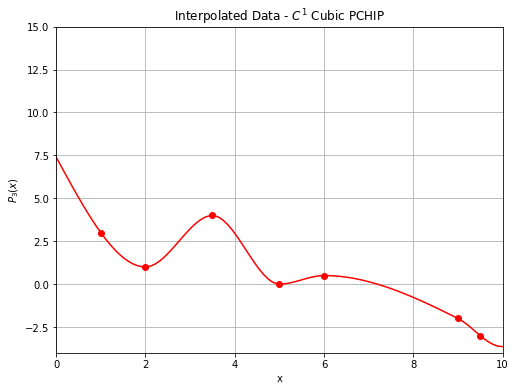

In [97]:
# Plot
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(data[:,0], data[:,1], 'ro')
axes.plot(x, P_pchip, 'r')

axes.set_title("Interpolated Data - $C^1$ Cubic PCHIP")
axes.set_xlabel("x")
axes.set_ylabel("$P_3(x)$")
axes.set_xlim([0.0, 10.0])
axes.set_ylim([-4.0, 15.0])
axes.grid()
plt.show()

#### Cubic Splines

Enforces continuity on second derivatives as well:

$$\mathcal{P}''_{k}(x_{k}) = \mathcal{P}''_{k-1}(x_k)$$

From our generalization before we know

$$\mathcal{P}''(s) = 6 (1-2s)(y_{k+1} - y_k) + (6s - 4) d_k + (6s-2) d_{k+1}$$

and our constraint now becomes

$$\mathcal{P}''_{k}(0) = \mathcal{P}''_{k-1}(1)$$

$$\mathcal{P}''_{k-1}(1) = 6 (1-2 \cdot 1)(y_{k} - y_{k-1}) + (6\cdot 1 - 4) d_{k-1} + (6\cdot 1-2) d_{k}$$

$$\mathcal{P}''_{k}(0) = 6 (1-2 \cdot 0)(y_{k+1} - y_k) + (6\cdot 0 - 4) d_k + (6\cdot 0-2) d_{k+1}$$

$$-6(y_{k} - y_{k-1}) + 2 d_{k-1} + 4 d_{k} = 6 (y_{k+1} - y_k) - 4 d_k -2  d_{k+1}$$

or rearrange knowns and unknowns to get.

$$
    2 d_{k-1} + 8 d_k + 2 d_{k+1} =  6 (y_{k+1} - y_{k-1}) 
$$ 

We now have constraints on choosing the $d_k$ values for all interior values of $k$.  Note that we still need to prescribe them at the boundaries of the full interval.

This forms a linear set of equations for the $d_k$s based on the $y_k$ values and can be reformulated into a tri-diagonal linear system

$$\begin{bmatrix}
         & \ddots  & \ddots  & \ddots  & &  &\\
         & 0 & 2 & 8 & 2 & 0 & & \\
         & & 0 & 2 & 8 & 2 & 0 & & & \\
         & &   & 0 & 2 & 8 & 2 & 0 & & \\
         & &    & & & \ddots & \ddots & \ddots &
\end{bmatrix}\begin{bmatrix}
    \vdots \\ d_{k-1} \\ d_{k} \\ d_{k+1} \\ \vdots
\end{bmatrix} = \begin{bmatrix}
    \vdots \\ 6 (y_{k} - y_{k-2}) \\ 6 (y_{k+1} - y_{k-1}) \\ 6 (y_{k+2} - y_{k}) \\\vdots
\end{bmatrix}$$

The boundaries are still left unconstrained and we must pick some rule to specify the derivatives there.

In [ ]:
from scipy.interpolate import UnivariateSpline

data = numpy.array([[1.0, 3.0], [2.0, 1.0], [3.5, 4.0], [5.0, 0.0], [6.0, 0.5], [9.0, -2.0], [9.5, -3.0]])
x = numpy.linspace(0.0, 10, 100)

# C^2 Piece-wise Splines
# Note that to get an interpolant we need to set the smoothing 
# parameters *s* to 0
P_spline = UnivariateSpline(data[:, 0], data[:, 1], s=0) 

In [ ]:
# Plot
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(data[:,0], data[:,1], 'ro')
axes.plot(x, P_spline(x), 'r', label = '$C^2$')
axes.plot(x, P_pchip, 'b--', label = 'Pchip')
axes.set_title("Interpolated Data - $C^2$ Cubic Splines")
axes.set_xlabel("x")
axes.set_ylabel("$P_3(x)$")
axes.set_xlim([0.0, 10.0])
axes.set_ylim([-4.0, 15.0])
axes.grid()
axes.legend(loc='best')

plt.show()

### Let's compare all of these methods

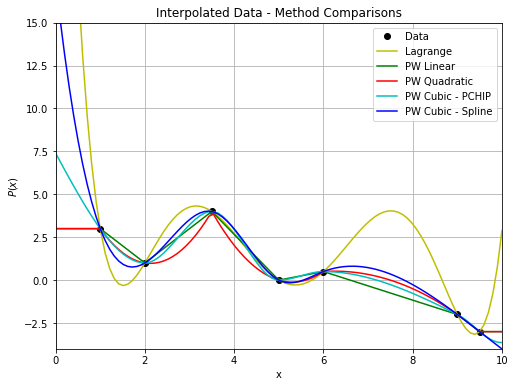

In [98]:
import scipy.interpolate as interpolate

data = numpy.array([[1.0, 3.0], [2.0, 1.0], [3.5, 4.0], [5.0, 0.0], [6.0, 0.5], [9.0, -2.0], [9.5, -3.0]])
x = numpy.linspace(0.0, 10, 100)

# Lagrange Basis
N = data.shape[0] - 1

lagrange_basis = numpy.ones((N + 1, x.shape[0]))
for i in range(N + 1):
    for j in range(N + 1):
        if i != j:
            lagrange_basis[i, :] *= (x - data[j, 0]) / (data[i, 0] - data[j, 0])

# Calculate full polynomial
P_lagrange = numpy.zeros(x.shape[0])
for n in range(N + 1):
    P_lagrange += lagrange_basis[n, :] * data[n, 1]

# C^0 Piece-wise linear
# P_pw_linear = numpy.interp(x, data[:, 0], data[:, 1])
P_linear = numpy.zeros(x.shape)
for n in range(1, N + 1):
    P_linear += ((data[n, 1] - data[n - 1, 1]) / (data[n, 0] - data[n - 1, 0]) * (x - data[n - 1, 0]) 
                         + data[n - 1, 1]) * (x > data[n - 1, 0]) * (x <= data[n, 0])
    
# Add end points for continuity
P_linear += numpy.ones(x.shape) * data[0, 1] * (x < data[0, 0])
P_linear += numpy.ones(x.shape) * data[-1, 1] * (x >= data[-1, 0])
# C^0 Piece-wise quadratic
P_quadratic = numpy.zeros(x.shape)
for k in range(1, N + 1, 2):
    p = numpy.polyfit(data[k - 1:k + 2, 0], data[k - 1:k + 2, 1], 2)
    P_quadratic += numpy.polyval(p, x) * (x > data[k - 1, 0]) * (x <= data[k + 1, 0])
# Add end points for continuity
P_quadratic += numpy.ones(x.shape) * data[0, 1] * (x < data[0, 0])
P_quadratic += numpy.ones(x.shape) * data[-1, 1] * (x >= data[-1, 0])
    
# C^1 Piece-wise PCHIP
P_pchip = interpolate.pchip_interpolate(data[:, 0], data[:, 1], x)

# C^2 Piece-wise Splines
P_spline = interpolate.UnivariateSpline(data[:, 0], data[:, 1], s=0)
    
# Plot
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(data[:,0], data[:,1], 'ko', label="Data")
axes.plot(x, P_lagrange, 'y', label="Lagrange")
axes.plot(x, P_linear, 'g', label="PW Linear") 
axes.plot(x, P_quadratic, 'r', label="PW Quadratic")
axes.plot(x, P_pchip, 'c', label="PW Cubic - PCHIP")
axes.plot(x, P_spline(x), 'b', label="PW Cubic - Spline")
axes.grid()

axes.set_title("Interpolated Data - Method Comparisons")
axes.set_xlabel("x")
axes.set_ylabel("$P(x)$")
axes.legend(loc='best')
axes.set_xlim([0.0, 10.0])
axes.set_ylim([-4.0, 15.0])

plt.show()

## Relationship to Regression

What if we have more data and want a lower degree polynomial but do not want to use a piece-wise defined interpolant?  
Regression techniques are often used to minimize a form of error between the data points $y_i$ at $x_i$ with an approximating function $f(x_i)$.  Note that this is NOT interpolation anymore!

### Least-Squares

One way of doing this is to require that we minimize the least-squares error
$$
    E = \left( \sum^m_{i=1} |y_i - f(x_i)|^2 \right )^{1/2}.
$$
where as before we have data $y_i$ at locations $x_i$ and an approximating function $f(x_i)$.

From the beginning of our discussion we know we can write the interpolant as a system of linear equations which we can then solve for the coefficients of a monomial basis.  If we wanted to fit a line 
$$
    \mathcal{P}_1(x) = p_0 + p_1 x
$$
to $N$ data points we would have
$$
   \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
        \vdots & \vdots \\
        1 & x_N
   \end{bmatrix} \begin{bmatrix}
       p_0 \\ p_1
   \end{bmatrix} = \begin{bmatrix}
       y_1 \\ y_2 \\ \vdots \\ y_N
   \end{bmatrix}
$$
or
$$
    A p = y
$$
What's wrong with this system?

This leads to the likelihood that there is no solution to the system as
$$
    A \in \mathbb{R}^{N \times 2}, p \in \mathbb{R}^{2 \times 1}, \text{  and  } y \in \mathbb{R}^{N \times 1}.
$$

Instead we can solve the related least-squares system
$$
    A^T A p = A^T y
$$
whose solution minimizes the least-square error defined before as $E$.

Note:  In general, this is not the most stable way to solve least squares problems,  in general, using an orthogonalization technique like $QR$ factorization is better numerically.

In [99]:
# Linear Least Squares Problem
N = 50
x = numpy.linspace(-1.0, 1.0, N)
y = x + numpy.random.random((N)) 

In [100]:
A = numpy.ones((x.shape[0], 2))
A[:, 1] = x
p = numpy.linalg.solve(numpy.dot(A.transpose(), A), numpy.dot(A.transpose(), y))
print('Normal Equations: p = {}'.format(p))
p = numpy.linalg.lstsq(A, y, rcond=None)[0]
print('Numpy Lstsq     : p = {}'.format(p))
f = lambda x: p[0] + p[1] * x
E = numpy.linalg.norm(y - f(x), ord=2)

Normal Equations: p = [0.47026621 0.95264233]
Numpy Lstsq     : p = [0.47026621 0.95264233]


In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, y, 'ko')
axes.plot(x, f(x), 'r')
axes.set_title("Least Squares Fit to Data, err={}".format(E))
axes.set_xlabel("$x$")
axes.set_ylabel("$f(x)$ and $y_i$")
axes.grid()

plt.show()

### Themes and variations

You can play all sorts of games, whether they are justified by the data or not,  for example we can fit the same random data with a function like

$$
    f(x) = p_0 + p_1\tanh(x)
$$

which is still a linear problem for the coefficients $p_0$ and $p_1$, however the vandermonde matrix now has columns of $\mathbf{1}$ and $\tanh\mathbf{x}$.

In [ ]:
# Linear Least Squares Problem
A = numpy.ones((x.shape[0], 2))
A[:, 1] = numpy.tanh(x)

In [ ]:
#p = numpy.linalg.solve(numpy.dot(A.transpose(), A), numpy.dot(A.transpose(), y))
p = numpy.linalg.lstsq(A, y,rcond=None)[0]
f = lambda x: p[0] + p[1] * numpy.tanh(x) 
E = numpy.linalg.norm(y - f(x), ord=2)

In [ ]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, y, 'ko')
axes.plot(x, f(x), 'r')
axes.set_title("Least Squares Fit to Data, err = {}".format(E))
axes.set_xlabel("$x$")
axes.set_ylabel("$f(x)$ and $y_i$")
axes.grid()

plt.show()

### Let ye be warned...

![curve-fitting methods](https://imgs.xkcd.com/comics/curve_fitting.png)

(Original image can be found at [Curve Fitting](https://xkcd.com/2048/).)